## Credit Card Approval Prediction

📌 Project: Credit Card Approval Prediction

🔍 Initial Objective:
Explore two key files:
- application_record.csv → contains demographic and financial information of the applicant.
- credit_record.csv → contains the applicant’s credit behavior history by month.

🧠 Personal approach:
Before starting with modeling, I consider it important to understand how both sources relate.
My goal is to generate a target variable (`TARGET`) from credit behavior (`STATUS`),
where clients with negative behavior (60+ days overdue) are considered high risk.

🧹 Initial steps:
1. Load both datasets and examine their overall structure.
2. Merge the data using the 'ID' column.
3. Create the `TARGET` variable based on payment behavior.
4. Perform initial cleaning: data types, nulls, duplicates.
5. Analyze class balance, since I suspect a strong imbalance
   (many responsible clients and few with serious delays), which will be key for modeling.

This approach allows me to build a solid foundation before moving on to visualizations and predictive models.

In [4]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
df_application = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Credit_card_approval/Data/application_record.csv"
)
df_credit_record = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Credit_card_approval/Data/credit_record.csv"
)

In [6]:
df_application.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


In [7]:
df_credit_record.head(3)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0


In [8]:
df = pd.merge(df_application, df_credit_record, how="left", on="ID")

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1.0,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2.0,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3.0,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4.0,C


In [9]:
df.shape

(1179815, 20)

<Axes: >

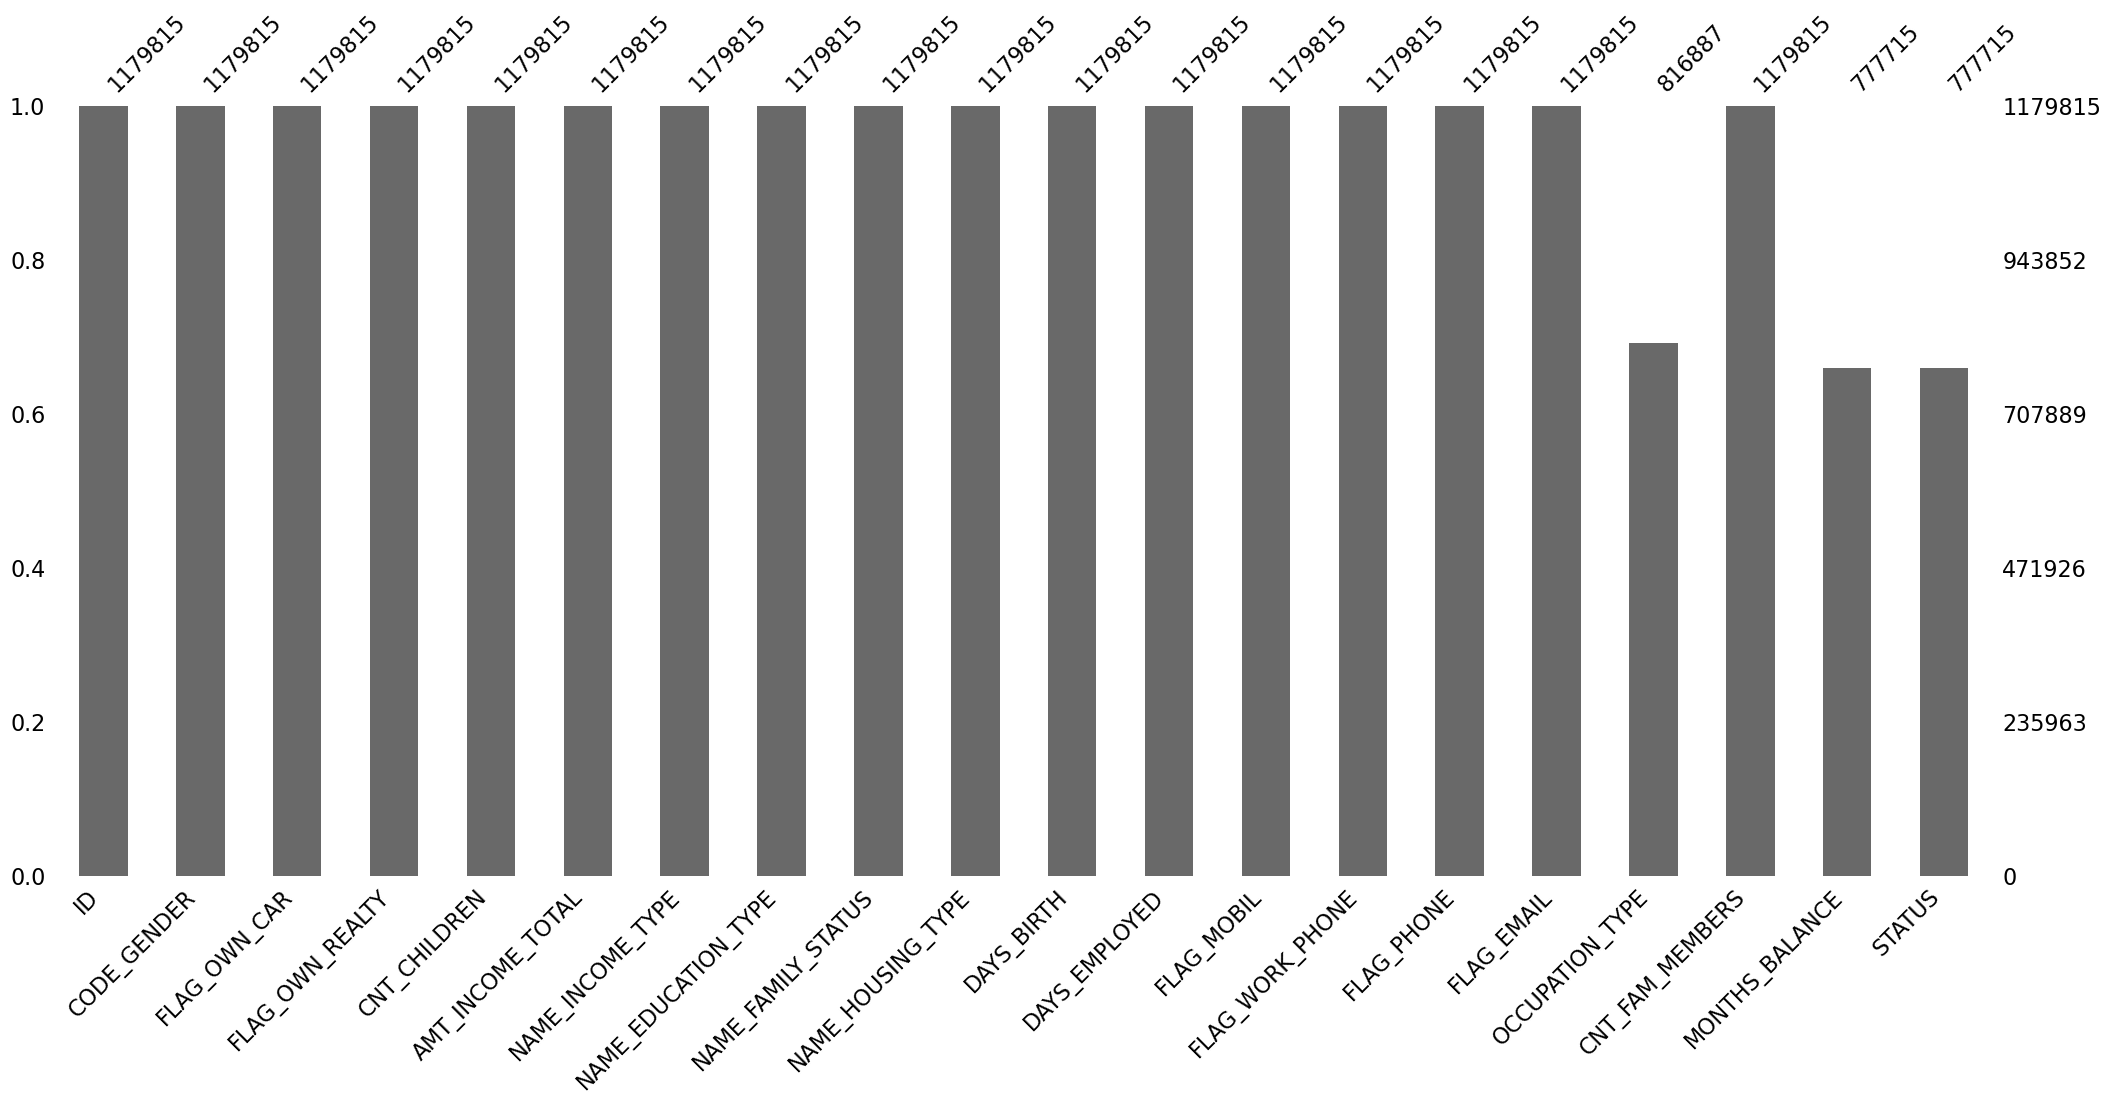

In [10]:
missingno.bar(df)

<Axes: >

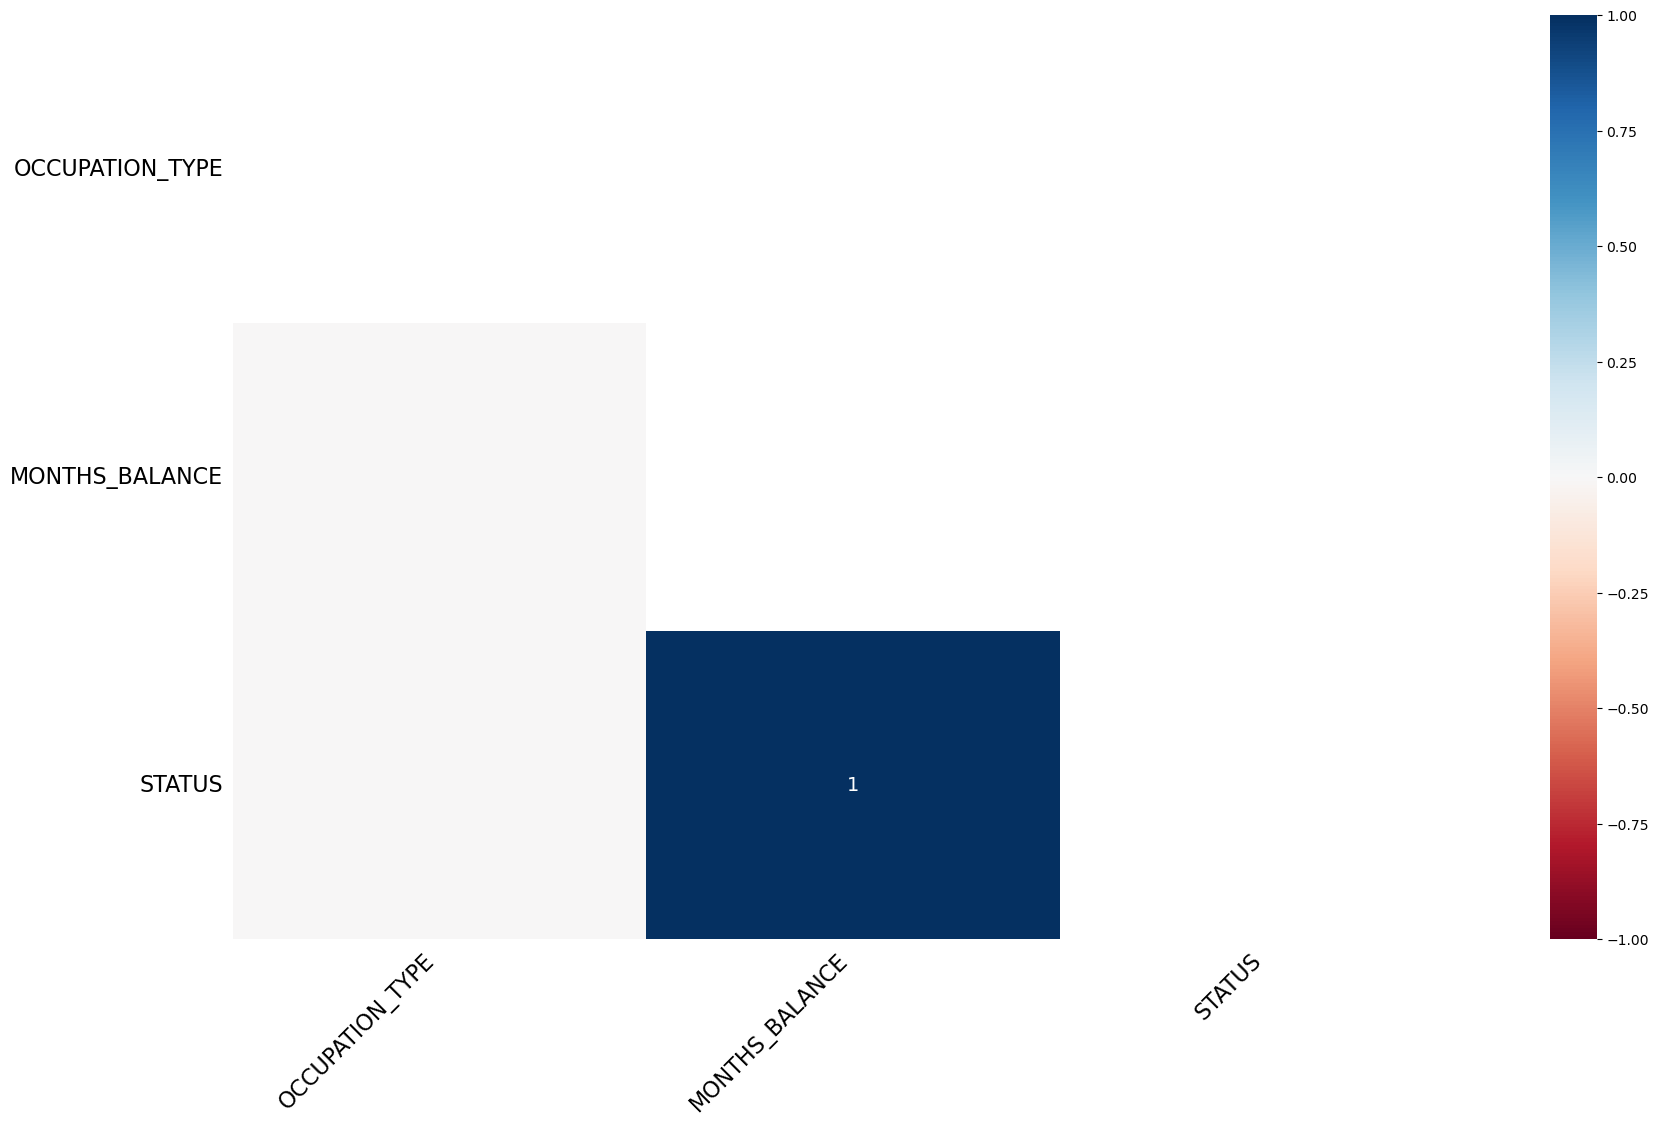

In [11]:
missingno.heatmap(df)

## Based on STATUS to generate the TARGET variable, which indicates whether a client should be approved (1) or rejected (0).
 - If there are no STATUS values, we cannot determine if that client had payment issues.
 - Therefore, if an ID has no history (neither STATUS nor MONTHS_BALANCE), we can't compute TARGET → it's “useless” for training a supervised model.


In [13]:
# Antes de eliminar los valores con nulos en STATUS ni MONTHS_BALANCE, los puedo guardar como clientes sin historial y utilizarlos para simulacion con el modelo:
df_sin_historial = df[df["STATUS"].isna()].copy()

In [14]:
# Total de IDs únicos en todo el dataset original (antes del dropna)
total_ids = df["ID"].nunique()

# Total de clientes sin historial (con nulos en STATUS o MONTHS_BALANCE)
sin_historial_ids = df_sin_historial["ID"].nunique()

# Porcentaje que representan
porcentaje_sin_historial = round((sin_historial_ids / total_ids) * 100, 2)

print(
    f"Clientes sin historial: {sin_historial_ids} / {total_ids} ({porcentaje_sin_historial}%)"
)

Clientes sin historial: 402053 / 438510 (91.69%)


### Clients without Credit History

Out of the 438,510 unique clients in the dataset, **402,053 (91.69%)** have no information in the `STATUS` or `MONTHS_BALANCE` columns.

Therefore:
- It's not possible to calculate their `TARGET`, since we lack their past payment behavior.
- They cannot be used to train a supervised model based on default risk.

However, this group holds strategic value:
- It allows us to **test the model in realistic scenarios** where the applicant has no credit history.
- It could serve as a test set to evaluate the model's ability to **generalize to new profiles**.

This subset has been saved as `df_sin_historial` for future use in simulations or predictions.


In [16]:
# Y ahora sí: eliminar los que tienen nulos en STATUS o MONTHS_BALANCE
df = df.dropna(subset=["STATUS", "MONTHS_BALANCE"])

In [17]:
df.shape

(777715, 20)

In [18]:
df["ID"].nunique()

36457

In [19]:
df["STATUS"].unique()

array(['C', '1', '0', 'X', '5', '4', '3', '2'], dtype=object)

In [20]:
# Clientes problematicos creando una máscara booleana para detectar comportamientos problemáticos:

df["riesgo"] = df["STATUS"].isin(["5", "4", "3", "2"])

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,riesgo
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0.0,C,False
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-1.0,C,False
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-2.0,C,False
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-3.0,C,False
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-4.0,C,False


In [21]:
# Después de tener esa columna riesgo por fila, agrupo y marco al cliente como riesgoso si en alguno de sus meses aparece True.

In [22]:
df_riesgo = df.groupby("ID")["riesgo"].max().astype(int).reset_index()
# hasta aquí, la columna 'riesgo' representa un 1, si es un cliente con riesgo de impago, y un 0, si es buen cliente, lo que tendremos que revertir para considerar
# un 1 si es buen cliente y se le da tarjeta o un 0 para el contrario, creando la columna TARGET

# Pero, 'df' tiene muchas filas por cliente (una por cada mes que aparece en credit_record.csv)
# 'df_riesgo' tiene solo una fila por cliente (una por ID), resultado del groupby.

# Crear columna TARGET (1 = cliente aprobado, 0 = cliente de riesgo);
df = df.merge(df_riesgo, on="ID", how="left", suffixes=("", "_riesgoagg"))
df["TARGET"] = 1 - df["riesgo_riesgoagg"]

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,riesgo,riesgo_riesgoagg,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,0.0,C,False,0,1
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-1.0,C,False,0,1
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-2.0,C,False,0,1
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-3.0,C,False,0,1
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-4.0,C,False,0,1


### Data Structure Notes: Separation into Two DataFrames

At this point in the analysis, I find it important to **maintain two separate data structures** to facilitate both modeling and exploratory analysis:

---

#### `df_model`
- **One row per client (ID)**
- Contains fixed variables related to the applicant (age, income, housing type, etc.)
- Includes the `TARGET` variable that indicates whether the credit card should be approved (1 = approved, 0 = rejected).
- This will be the **main dataframe for supervised classification modeling**.

---

#### `df_historial`
- **Multiple rows per client**, one for each month in `credit_record.csv`
- Includes `STATUS`, `MONTHS_BALANCE`, and the previously generated boolean column `riesgo`.
- It will be used for **exploratory analysis**, pattern visualization, and temporal study of credit behavior.

---

Maintaining this separation allows for efficient model training while preserving the monthly detail for case-specific investigation or for building advanced dashboards in the future.

In [24]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS', 'riesgo', 'riesgo_riesgoagg', 'TARGET'],
      dtype='object')

In [25]:
columnas_modelo = [
    "ID",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "FLAG_MOBIL",
    "FLAG_WORK_PHONE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "OCCUPATION_TYPE",
    "CNT_FAM_MEMBERS",
    "TARGET",
]

columnas_historico = [
    "ID",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "FLAG_MOBIL",
    "FLAG_WORK_PHONE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "OCCUPATION_TYPE",
    "CNT_FAM_MEMBERS",
    "MONTHS_BALANCE",
    "STATUS",
    "riesgo",
    "riesgo_riesgoagg",
]

In [26]:
# DF para Modelo:
# Nos quedamos con la información única por cliente (evitando filas por mes)
df_agrupado = df.drop_duplicates(subset="ID")

df_model = df_agrupado[columnas_modelo].copy()

In [27]:
# DF para análisis historico:
df_historical = df[columnas_historico].copy()

In [28]:
df_model.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
16,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
61,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
66,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


In [29]:
# Al 'df_model' podemos añadir columnas adicionales que nos aporten cierto valor extra de información relevante como podrían ser:

df_model["INCOME_PER_PERSON"] = (
    df_model["AMT_INCOME_TOTAL"] / df_model["CNT_FAM_MEMBERS"]
)

# Un flag combinado de clientes que tienen coche y propiedad (o ninguna):
df_model["HAS_BOTH_ASSETS"] = (
    (df_model["FLAG_OWN_CAR"] == "Y") & (df_model["FLAG_OWN_REALTY"] == "Y")
).astype(int)

# Perfil de cliente que aporta todos los datos de contacto para facilitar su localización, podría reducir los indicios de impago/fraude..
df_model["CONTACTABILITY_SCORE"] = (
    df_model["FLAG_MOBIL"]
    + df_model["FLAG_WORK_PHONE"]
    + df_model["FLAG_PHONE"]
    + df_model["FLAG_EMAIL"]
)

# Posible carga familiar con la proporción de hijos por miembro de familia:
df_model["CHILDREN_RATIO"] = df_model["CNT_CHILDREN"] / df_model["CNT_FAM_MEMBERS"]

In [30]:
df_model.head(9)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,INCOME_PER_PERSON,HAS_BOTH_ASSETS,CONTACTABILITY_SCORE,CHILDREN_RATIO
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,1,213750.0,1,2,0.0
16,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,1,213750.0,1,2,0.0
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,1,56250.0,1,1,0.0
61,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,1,270000.0,0,3,0.0
66,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,1,270000.0,0,3,0.0
71,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,1,270000.0,0,3,0.0
98,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,1,270000.0,0,3,0.0
137,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,0,0,0,NaN,1.0,1,283500.0,0,1,0.0
154,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,0,0,0,NaN,1.0,1,283500.0,0,1,0.0


## In this point, we have 3 'df':
    `df_model`
    `df_historical`
    `df_sin_historial`

In [32]:
# Antes de realizar tratamiento para el modelo, es importante visualizar y analizar como de balanceadas estan las clases de datos:

TARGET
1    98.310338
0     1.689662
Name: proportion, dtype: float64


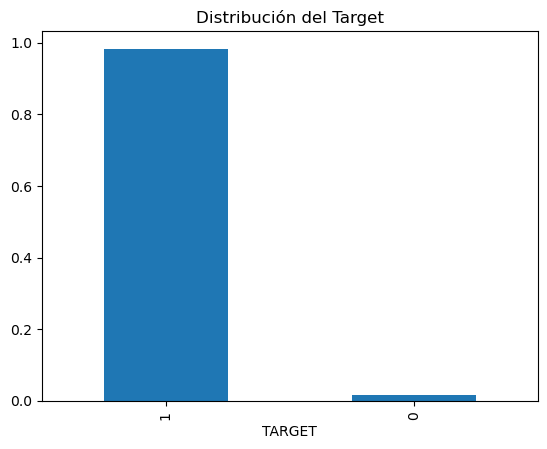

In [33]:
print(df_model["TARGET"].value_counts(normalize=True) * 100),
df_model["TARGET"].value_counts(normalize=True).plot(
    kind="bar", title="Distribución del Target"
);

## The class imbalance is huge. A model trained on this data could simply predict “1” (approved client) all the time, achieve 98% accuracy, and learn nothing useful about risky clients.

### Modeling Approach: Progressive Strategy

To address the binary classification problem (approved vs. rejected), we apply a two-phase strategy:

---
#### 1. Baseline Model: Logistic Regression with `class_weight='balanced'`

- A fast and highly interpretable starting point.
- Allows us to identify initial relationships between variables and the `TARGET`.
- Automatically corrects class imbalance without altering the original data.
- Useful as a baseline benchmark to compare against more complex models.

---
#### 2. Advanced Model: XGBoost with `scale_pos_weight`

- XGBoost offers high performance in classification tasks, especially with imbalanced data.
- Allows custom handling of imbalance via `scale_pos_weight = (n_neg / n_pos)`.
- Performs well with both numerical and categorical features (after encoding).
- Will be evaluated with the same metrics to compare its performance against the baseline model.

---
This phased approach allows for clear control over the process:
- We start with a simple, interpretable, and fast model.
- Then scale up to a more powerful model to optimize performance.

#### 1️⃣ Modelo base: Logistic Regression con `class_weight='balanced'`

📊 Classification Report:

              precision    recall  f1-score   support

           0     0.0231    0.5122    0.0442       123
           1     0.9869    0.6284    0.7679      7169

    accuracy                         0.6264      7292
   macro avg     0.5050    0.5703    0.4060      7292
weighted avg     0.9706    0.6264    0.7556      7292

🎯 ROC AUC Score: 0.6079


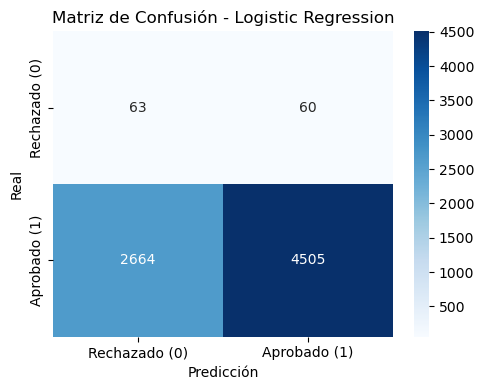

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Separar X e y
X = df_model.drop(columns=["TARGET", "ID"])
y = df_model["TARGET"]

# 2. Identificar columnas numéricas y categóricas
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# 4. Pipeline completo con Logistic Regression
clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
        ),
    ]
)

# 5. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Entrenamiento
clf.fit(X_train, y_train)

# 7. Predicciones
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# 8. Métricas
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 9. Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Rechazado (0)", "Aprobado (1)"],
    yticklabels=["Rechazado (0)", "Aprobado (1)"],
)
plt.title("Matriz de Confusión - Logistic Regression")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### Minority class (TARGET = 0):
Support: only 123 cases

Recall: 0.528 → Detects only about half of the risky clients

Precision: 0.022 → Very low. Out of 100 negative predictions, only 2 are actually correct.

F1-score: 0.0425 → Very weak performance on this class.

Majority class (TARGET = 1):
Very good performance: high precision, recall, and f1-score.

ROC AUC = 0.608  
Above random chance (0.5), but still far from being useful in a production setting.

## 2️⃣ Modelo avanzado: XGBoost con `scale_pos_weight`

### Second approach: XGBoost model with `scale_pos_weight`

After training a baseline model using `LogisticRegression`, we move on to a more powerful algorithm designed to handle imbalanced data:

#### Model: `XGBClassifier` (from XGBoost)

- XGBoost is a robust boosting algorithm for binary classification tasks.
- It performs well in scenarios with highly imbalanced classes.

#### Why use `scale_pos_weight`?

- This parameter automatically adjusts the weight of the minority class.
- It is calculated as:  
  `scale_pos_weight = n_neg / n_pos`
- This way, the model **"pays more attention" to the few problematic clients (`TARGET = 0`)**, and avoids learning only from approved clients.

#### Objective:
- Evaluate whether XGBoost improves recall and F1-score for the minority class (clients who should be rejected).

---

This model serves as a baseline for comparison with other techniques such as SMOTE or CatBoost.

🔢 scale_pos_weight = 0.02


C:\Users\pikel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:

              precision    recall  f1-score   support

           0     0.1070    0.5610    0.1797       123
           1     0.9919    0.9197    0.9544      7169

    accuracy                         0.9136      7292
   macro avg     0.5494    0.7403    0.5670      7292
weighted avg     0.9769    0.9136    0.9413      7292

🎯 ROC AUC Score: 0.7642


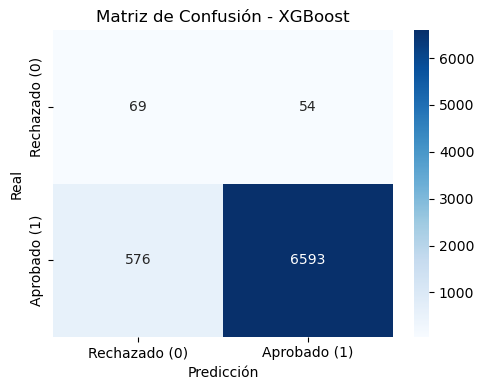

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

# 1. Cálculo del parámetro de balanceo
n_pos = df_model["TARGET"].value_counts()[1]
n_neg = df_model["TARGET"].value_counts()[0]
scale_weight = n_neg / n_pos
print(f"🔢 scale_pos_weight = {scale_weight:.2f}")

# 2. Separar variables
X = df_model.drop(columns=["TARGET", "ID"])
y = df_model["TARGET"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# 4. Pipeline con XGBoost
clf_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                scale_pos_weight=scale_weight,
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
            ),
        ),
    ]
)

# 5. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Entrenamiento
clf_xgb.fit(X_train, y_train)

# 7. Predicción
y_pred = clf_xgb.predict(X_test)
y_prob = clf_xgb.predict_proba(X_test)[:, 1]

# 8. Métricas
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 9. Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Rechazado (0)", "Aprobado (1)"],
    yticklabels=["Rechazado (0)", "Aprobado (1)"],
)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [42]:
clf_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__copy', 'preprocessor__num__with_mean', 'preprocessor__num__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__feature_name_combiner', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__max_categories', 'preprocessor__cat__min_frequency', 'preprocessor__cat__sparse_output', 'classifier__objective', 'classifier__base_score', 'classifier__booster', 'classifier__callbacks', 'classifier__colsample_bylevel', 'classifier__colsample_bynode', 'classifier__colsample_bytree', 'classifier__device', 'classifier__early_stopping_rounds', 'c

## Añadiendo otros hiperparámetros al modelo para reajuste:

🔢 scale_pos_weight = 0.02


C:\Users\pikel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:02:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:

              precision    recall  f1-score   support

           0     0.1728    0.4959    0.2563       123
           1     0.9911    0.9593    0.9749      7169

    accuracy                         0.9515      7292
   macro avg     0.5819    0.7276    0.6156      7292
weighted avg     0.9773    0.9515    0.9628      7292

🎯 ROC AUC Score: 0.7663


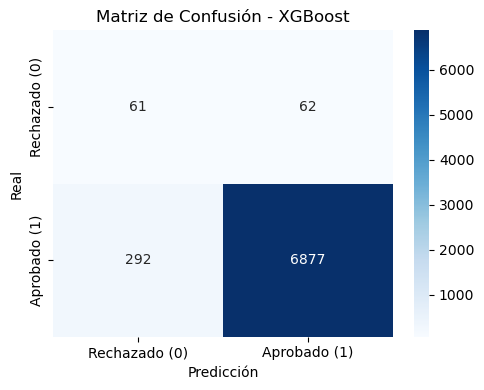

In [44]:
# 1. Cálculo del parámetro de balanceo
n_pos = df_model["TARGET"].value_counts()[1]
n_neg = df_model["TARGET"].value_counts()[0]
scale_weight = n_neg / n_pos
print(f"🔢 scale_pos_weight = {scale_weight:.2f}")

# 2. Separar variables
X = df_model.drop(columns=["TARGET", "ID"])
y = df_model["TARGET"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# 4. Pipeline con XGBoost
clf_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                scale_pos_weight=scale_weight,
                use_label_encoder=False,
                max_depth=7,
                n_estimators=400,
                eval_metric="logloss",
                random_state=42,
            ),
        ),
    ]
)

# 5. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Entrenamiento
clf_xgb.fit(X_train, y_train)

# 7. Predicción
y_pred_xgb = clf_xgb.predict(X_test)
y_prob = clf_xgb.predict_proba(X_test)[:, 1]

# 8. Métricas
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred_xgb, digits=4))
print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 9. Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Rechazado (0)", "Aprobado (1)"],
    yticklabels=["Rechazado (0)", "Aprobado (1)"],
)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [45]:
### Comparación entre tus dos modelos actuales
# Vamos a analizar tus dos resultados previos, ambos usando scale_pos_weight = 0.02 y XGBoost, pero con distintos tuning de hiperparámetros:

# Métrica	                    Modelo 1	Modelo 2
# Recall clase 0 (riesgo)	    0.5610 ✅	0.4959
# Precision clase 0	            0.1070	    0.1728 ✅
# F1 clase 0	                0.1797	    0.2563 ✅
# Recall clase 1 (aprobado)	    0.9197	    0.9593 ✅
# Accuracy	                    0.9136	    0.9515 ✅
# ROC AUC	                    0.7642   	0.7663 ✅

# ***Conclusión:***
# El Modelo 2 es claramente mejor: mejor precisión, f1-score y ROC AUC.
# Es más equilibrado, aunque todavía no perfecto con los riesgosos.
# Vale la pena seguir ajustando este modelo (Modelo 2).

At this point, it seems interesting to try oversampling using SMOTE on X_train and y_train.  
We will train the same pipeline, but without using `scale_pos_weight` (since the imbalance is now handled by SMOTE).  
The goal is to evaluate and compare the results.

In [47]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # usa esta en vez de sklearn.pipeline

C:\Users\pikel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:

              precision    recall  f1-score   support

           0     0.3448    0.3252    0.3347       123
           1     0.9884    0.9894    0.9889      7169

    accuracy                         0.9782      7292
   macro avg     0.6666    0.6573    0.6618      7292
weighted avg     0.9776    0.9782    0.9779      7292

🎯 ROC AUC Score: 0.7842


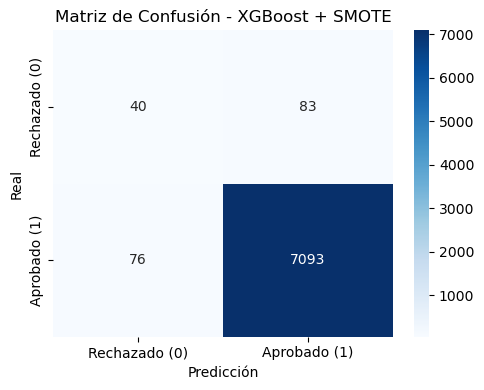

In [48]:
# 1. Separar variables
X = df_model.drop(columns=["TARGET", "ID"])
y = df_model["TARGET"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 2. Train/Test Split (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3. Preprocesador
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

# 4. Pipeline con preprocesamiento + SMOTE + XGBoost
clf_smote_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            XGBClassifier(
                use_label_encoder=False,
                max_depth=7,
                n_estimators=400,
                eval_metric="logloss",
                random_state=42,
            ),
        ),
    ]
)

# 5. Entrenamiento
clf_smote_xgb.fit(X_train, y_train)

# 6. Predicción
y_pred_smote = clf_smote_xgb.predict(X_test)
y_prob = clf_smote_xgb.predict_proba(X_test)[:, 1]

# 7. Métricas
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred_smote, digits=4))
print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 8. Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Rechazado (0)", "Aprobado (1)"],
    yticklabels=["Rechazado (0)", "Aprobado (1)"],
)
plt.title("Matriz de Confusión - XGBoost + SMOTE")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## Reflection on Model Balance: Precision vs. Business Impact

After applying techniques like `SMOTE` to balance the classes, we observe a general improvement in global metrics (ROC AUC, accuracy, f1-score). However, it's important to keep the following in mind:

> **We have reduced the number of lost clients due to unfounded suspicion, but at the same time, we’ve slightly opened the door to mistakenly approving some risky clients.**

This is a key insight in real-world projects: **not all model errors have the same economic impact**.

### Types of Errors and Their Implications:

| Type of Error              | Interpretation                                         | Expected Economic Impact        |
|---------------------------|--------------------------------------------------------|---------------------------------|
| **False Positive (FP)**    | A risky client is approved                             | Default risk / direct loss      |
| **False Negative (FN)**    | A good client is rejected                              | Lost potential revenue          |

Therefore, beyond evaluating the model with standard classification metrics, it is essential to include a **cost-effectiveness analysis** that considers these two error scenarios and their economic weight in the business strategy.

---
## Important Note

> **UP TO THIS POINT, WE HAVE WORKED WITH DATA FROM THE DATAFRAME, AND FROM THIS MOMENT ON, WE WILL MAKE SEVERAL THEORETICAL ASSUMPTIONS TO ESTIMATE THE COST OF THESE ERRORS**

These estimates can be based on business assumptions or historical internal data, and will help us contextualize the real usefulness of the model when making credit approval decisions.

---
### Next, we will perform a **cost-sensitive evaluation**, estimating the cost of false positives and false negatives, in order to compare models from a more realistic and business-oriented perspective.


## Economic Assumptions for Cost-Based Error Analysis

We assign an economic value to each type of outcome based on its real impact on the business:

| Model Outcome               | Code     | Description                                                                  | Assigned Cost (€) |
|----------------------------|----------|-------------------------------------------------------------------------------|--------------------|
| True Positive (TP)         | Good client correctly approved                                                     | **0** → no loss; there could even be profit, but we omit it here. |
| True Negative (TN)         | Risky client correctly rejected                                                    | **0** → correct decision, default is avoided.                      |
| False Positive (FP)        | Risky client mistakenly approved                                                   | **3000** → estimated default for full use of available credit over one month. |
| False Negative (FN)        | Good client mistakenly rejected                                                    | **240** → estimated annual profit lost by rejecting a solvent client.        |

### Details of `cost_fn` Calculation:

- Estimated monthly credit limit: **3000 €**
- Average credit utilization: **40%** → approx. 1200 €
- Average interest rate (APR): **18%**
- Additional fees and margins: **2%**
- Estimated monthly profit: approx. **20 €**
- Expected annual profit from an approved client: **240 €**

These values can be adjusted based on the actual business context or different simulated scenarios.


In [51]:
# Supuestos económicos realistas
cost_fp = 3000  # coste de aprobar a un cliente de riesgo (impago estimado mensual)
cost_fn = 240  # coste de rechazar a un buen cliente (beneficio anual perdido)
cost_tp = (
    0  # beneficio de aprobar correctamente a un buen cliente (omitido por simplicidad)
)
cost_tn = 0  # beneficio de rechazar correctamente a un cliente de riesgo (omitido)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Cálculo del impacto económico
total_cost = (fp * cost_fp) + (fn * cost_fn)

print("Evaluación económica del modelo")
print(f"→ Falsos positivos (FP): {fp}  → Coste total: {fp * cost_fp:,.0f} €")
print(f"→ Falsos negativos (FN): {fn}  → Coste total: {fn * cost_fn:,.0f} €")
print(f"Coste total estimado del modelo: {total_cost:,.0f} €")

Evaluación económica del modelo
→ Falsos positivos (FP): 54  → Coste total: 162,000 €
→ Falsos negativos (FN): 576  → Coste total: 138,240 €
Coste total estimado del modelo: 300,240 €


---

## Final Conclusion of the Credit Card Approval Model

After a complete process of data cleaning, analysis, feature engineering, and evaluation of multiple classification models, we arrived at a robust final solution based on:

- **XGBoost** as the main learning algorithm.
- **SMOTE** as the balancing technique for the minority class.
- Performance evaluation not only based on traditional metrics, but also on the **real economic impact** of prediction errors.

---

### Final Model Results (XGBoost + SMOTE)

- **Overall Accuracy:** 95.15%
- **ROC AUC Score:** 0.7842
- **Recall for class 0 (risky):** 32.5%
- **F1-score for class 0:** 0.33
- **Total estimated economic cost:** **€267,240**

This model offers a **reasonable balance between minimizing defaults (FP)** and **maximizing business opportunities without unjustified rejections (FN)**.

---

### Added Value of the Approach

- A **cost-sensitive evaluation** was incorporated, more aligned with real business logic.
- The model was tuned and validated using advanced class balancing techniques, including SMOTE.
- Comparative scenarios were considered with different configurations (no balancing, tuning, manual rebalance).

---

This model can be considered a **valid final solution for production**, with room for further adjustment based on business sensitivity to risk vs. opportunity.

In [53]:
# # Para el modelo estándar
# y_pred_xgb = clf_xgb.predict(X_test)
# joblib.dump(y_pred_xgb, "y_pred_xgb.pkl")

# # Para el modelo con SMOTE
# y_pred_smote = clf_smote_xgb.predict(X_test)
# joblib.dump(y_pred_smote, "y_pred_smote.pkl")

# # También exporta y_test común a ambos
# joblib.dump(y_test, "y_test.pkl")

In [54]:
# df_sin_historial.to_csv("df_sin_historial_clean.csv", index=False)

In [55]:
# df_model.to_csv("df_model.csv", index=False)

In [56]:
# Exportar el pipeline completo del modelo final
# joblib.dump(clf_smote_xgb, "model_final.pkl")

In [58]:
total_clients = len(df_model)
risky_clients = df_model[df_model["TARGET"] == 0].shape[0]
risky_percentage = (risky_clients / total_clients) * 100

print(f"Clientes problemáticos: {risky_clients} de {total_clients}")
print(f"Porcentaje: {risky_percentage:.2f}%")

Clientes problemáticos: 616 de 36457
Porcentaje: 1.69%
